# TLT SSD example usecase

This notebook shows an example usecase of SSD object detection using Transfer Learning Toolkit.

0. [Set up env variables](#head-0)
1. [Prepare dataset and pre-trained model](#head-1) <br>
    1.1 [Prepare tfrecords from kitti format dataset](#head-1-1) <br>
    1.2 [Download pre-trained model](#head-1-2) <br>
2. [Provide training specification](#head-2)
3. [Run TLT training](#head-3)
4. [Evaluate trained models](#head-4)
5. [Prune trained models](#head-5)
6. [Retrain pruned models](#head-6)
7. [Evaluate retrained model](#head-7)
8. [Visualize inferences](#head-8)
9. [Deploy](#head-9)
10. [Verify deployed model](#head-10)

## 0. Set up env variables <a class="anchor" id="head-0"></a>


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Setting up env variables for cleaner command line commands.
print("Please replace the variable with your key.")
%set_env KEY=MzYwbm5pcGpxdmRxMHA1cjN2cnJodGtrYXE6YTJmMjE4MWEtM2E0Ni00MzhkLWI2YTItOWU0YzQ2MzRlZTgy
%set_env USER_EXPERIMENT_DIR=/work/tlt/ped_ssd_mobilenet_v2
%set_env DATA_DOWNLOAD_DIR=/work/tlt/oxford_town_center
%set_env SPECS_DIR=/work/tlt/ped_ssd_mobilenet_v2/specs

Please replace the variable with your key.
env: KEY=MzYwbm5pcGpxdmRxMHA1cjN2cnJodGtrYXE6YTJmMjE4MWEtM2E0Ni00MzhkLWI2YTItOWU0YzQ2MzRlZTgy
env: USER_EXPERIMENT_DIR=/work/tlt/ped_ssd_mobilenet_v2
env: DATA_DOWNLOAD_DIR=/work/tlt/oxford_town_center
env: SPECS_DIR=/work/tlt/ped_ssd_mobilenet_v2/specs


## 1. Prepare dataset and pre-trained model <a class="anchor" id="head-1"></a>

 We will be using the KITTI detection dataset for the tutorial. To find more details please visit
 http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d. Please download the KITTI detection images (http://www.cvlibs.net/download.php?file=data_object_image_2.zip) and labels (http://www.cvlibs.net/download.php?file=data_object_label_2.zip) to $DATA_DOWNLOAD_DIR.

In [2]:
# Check the dataset is present
!mkdir -p $DATA_DOWNLOAD_DIR
!if [ ! -f $DATA_DOWNLOAD_DIR/data_object_image_2.zip ]; then echo 'Image zip file not found, please download.'; else echo 'Found Image zip file.';fi
!if [ ! -f $DATA_DOWNLOAD_DIR/data_object_label_2.zip ]; then echo 'Label zip file not found, please download.'; else echo 'Found Labels zip file.';fi

Image zip file not found, please download.
Label zip file not found, please download.


In [ ]:
# unpack 
!unzip -u $DATA_DOWNLOAD_DIR/data_object_image_2.zip -d $DATA_DOWNLOAD_DIR
!unzip -u $DATA_DOWNLOAD_DIR/data_object_label_2.zip -d $DATA_DOWNLOAD_DIR

In [ ]:
# verify
!ls -l $DATA_DOWNLOAD_DIR/

Additionally, if you have your own dataset already in a volume (or folder), you can mount the volume on `DATA_DOWNLOAD_DIR` (or create a soft link). Below shows an example:
```bash
# if your dataset is in /dev/sdc1
mount /dev/sdc1 $DATA_DOWNLOAD_DIR

# if your dataset is in folder /var/dataset
ln -sf /var/dataset $DATA_DOWNLOAD_DIR
```

### 1.1 Prepare tfrecords from kitti format dataset <a class="anchor" id="head-1-1"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the tlt-dataset-convert 
* TFRecords only need to be generated once.

In [2]:
print("TFrecords conversion spec file for training")
!cat $SPECS_DIR/ssd_tfrecords_kitti_trainval.txt

TFrecords conversion spec file for training
kitti_config {
  root_directory_path: "/work/tlt/oxford_town_center"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 14
  num_shards: 10
}
image_directory_path: "/work/tlt/oxford_town_center"


In [4]:
# Creating a new directory for the output tfrecords dump.
# !mkdir -p $USER_EXPERIMENT_DIR/tfrecords
#KITTI trainval
!tlt-dataset-convert -d $SPECS_DIR/ssd_tfrecords_kitti_trainval.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/

Using TensorFlow backend.
2020-05-03 11:54:47,129 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2020-05-03 11:54:47,138 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 3871	Val: 630
2020-05-03 11:54:47,138 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2020-05-03 11:54:47,139 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0
/usr/local/lib/python2.7/dist-packages/iva/detectnet_v2/dataio/kitti_converter_lib.py:266: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
2020-05-03 11:54:47,271 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 1
2020-05-03 11:54:47,338 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing pa

In [5]:
!ls -rlt $DATA_DOWNLOAD_DIR/tfrecords/

total 6956
-rw-r--r-- 1 root root 101813 May  3 11:54 -fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root  99601 May  3 11:54 -fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 root root  97923 May  3 11:54 -fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 root root 100609 May  3 11:54 -fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 root root  97446 May  3 11:54 -fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 root root  98696 May  3 11:54 -fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 root root 100370 May  3 11:54 -fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 root root  99646 May  3 11:54 -fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 root root  99413 May  3 11:54 -fold-000-of-002-shard-00008-of-00010
-rw-r--r-- 1 root root 102227 May  3 11:54 -fold-000-of-002-shard-00009-of-00010
-rw-r--r-- 1 root root 614676 May  3 11:54 -fold-001-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root 606124 May  3 11:54 -fold-001-of-002-shard-00001-of-00010
-rw-r--r-- 1 root

### 1.2 Download pre-trained model <a class="anchor" id="head-1-2"></a>

We will use NGC CLI to get the pre-trained models. For more details, go to [ngc.nvidia.com](ngc.nvidia.com) and click the SETUP on the navigation bar.

In [6]:
!ngc registry model list nvidia/tlt_pretrained_object_detection:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| resne | 74.38 | 80    | 1     | V100  | 38.3  | 38.31 | UPLOA | Apr   |
| t10   |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| resne | 76.74 | 80    | 1     | V100  | 89.0  | 88.96 | UPLOA | Apr   |
| t18   |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| resne | 77.04 | 80    | 1     | V100  | 170.7 | 170.6 | UPLOA | Apr   |
| t34   |       |       |       |     

In [7]:
!mkdir -p $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/

In [8]:
# Pull pretrained model from NGC
!ngc registry model download-version nvidia/tlt_pretrained_object_detection:mobilenet_v2 --dest $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2

Downloaded 4.3 MB in 2s, Download speed: 2.15 MB/s               
----------------------------------------------------
Transfer id: tlt_pretrained_object_detection_vmobilenet_v2 Download status: Completed.
Downloaded local path: /work/tlt/ped_ssd_mobilenet_v2/pretrained_mobilenet_v2/tlt_pretrained_object_detection_vmobilenet_v2
Total files downloaded: 1 
Total downloaded size: 4.3 MB
Started at: 2020-05-03 11:58:20.238558
Completed at: 2020-05-03 11:58:22.243585
Duration taken: 2s
----------------------------------------------------


In [11]:
print("Check that model is downloaded into dir.")
!ls -lh $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/tlt_pretrained_object_detection_vmobilenet_v2

Check that model is downloaded into dir.
total 5.1M
-rw------- 1 root root 5.1M May  3 11:58 mobilenet_v2.hdf5


## 2. Provide training specification <a class="anchor" id="head-2"></a>
* Tfrecords for the train datasets
    * In order to use the newly generated tfrecords, update the dataset_config parameter in the spec file at `$SPECS_DIR/ssd_train_resnet18_kitti.txt` 
    * Update the fold number to use for evaluation. In case of random data split, please use fold 0 only
    * For sequence wise you may use any fold generated from the dataset convert tool
* Pre-trained models
* Augmentation parameters for on the fly data augmentation
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [12]:
!cat $SPECS_DIR/ped_ssd_mobilenet_v2_train.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.1, 0.24166667, 0.38333333, 0.525, 0.66666667, 0.80833333, 0.95]"
  two_boxes_for_ar1: true
  clip_boxes: false
  loss_loc_weight: 1.0
  focal_loss_alpha: 0.25
  focal_loss_gamma: 2.0
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "mobilenet_v2"
  freeze_bn: false
}
training_config {
  batch_size_per_gpu: 24
  num_epochs: 300
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-5
    max_learning_rate: 2e-2
    soft_start: 0.15
    annealing: 0.5
    }
  }
  regularizer {
    type: L1
    weight: 3e-06
  }
}
eval_config {
  validation_period_during_training: 10
  average_precision_mode: SAMPLE
  batch_size: 32
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
  preprocessing {
    output_image_width: 1248
    output_image_height: 384
    output_image_channel: 3
    crop_right:

## 3. Run TLT training <a class="anchor" id="head-3"></a>
* Provide the sample spec file and the output directory location for models
* WARNING: training will take several hours or one day to complete

In [13]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_unpruned

In [17]:
print("To run with multigpu, please change --gpus based on the number of available GPUs in your machine.")
!tlt-train ssd -e $SPECS_DIR/ped_ssd_mobilenet_v2_train.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
               -k $KEY \
               -m $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/tlt_pretrained_object_detection_vmobilenet_v2/mobilenet_v2.hdf5 \
               --gpus 1

To run with multigpu, please change --gpus based on the number of available GPUs in your machine.
Using TensorFlow backend.
2020-05-03 13:13:54,302 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /work/tlt/ped_ssd_mobilenet_v2/specs/ped_ssd_mobilenet_v2_train.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/trunca

Epoch 1/250
242/242 [==============================] - 64s 265ms/step - loss: 29.2153

Epoch 00001: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_001.tlt
Epoch 2/250
242/242 [==============================] - 52s 214ms/step - loss: 4.7470

Epoch 00002: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_002.tlt
Epoch 3/250
242/242 [==============================] - 52s 214ms/step - loss: 4.0049

Epoch 00003: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_003.tlt
Epoch 4/250
242/242 [==============================] - 52s 214ms/step - loss: 3.6317

Epoch 00004: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_004.tlt
Epoch 5/250
242/242 [==============================] - 52s 215ms/step - loss: 3.4082

Epoch 00005: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_un

242/242 [==============================] - 52s 215ms/step - loss: 1.1554

Epoch 00036: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_036.tlt
Epoch 37/250
242/242 [==============================] - 52s 215ms/step - loss: 1.1345

Epoch 00037: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_037.tlt
Epoch 38/250
242/242 [==============================] - 52s 215ms/step - loss: 1.1212

Epoch 00038: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_038.tlt
Epoch 39/250
242/242 [==============================] - 52s 215ms/step - loss: 1.0843

Epoch 00039: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_039.tlt
Epoch 40/250
242/242 [==============================] - 52s 217ms/step - loss: 1.0486

Epoch 00040: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/we

Number of images in the evaluation dataset: 630

Producing predictions: 100%|████████████████████| 20/20 [00:11<00:00,  1.68it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
pedestrian    AP    0.862
              mAP   0.862
*******************************
Epoch 71/250
242/242 [==============================] - 52s 216ms/step - loss: 0.8196

Epoch 00071: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_071.tlt
Epoch 72/250
242/242 [==============================] - 52s 215ms/step - loss: 0.8024

Epoch 00072: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_072.tlt
Epoch 73/250
242/242 [==============================] - 52s 216ms/step - loss: 0.8062

Epoch 00073: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_073.tlt
Epoch 74/250
242/242 [===========================

242/242 [==============================] - 52s 216ms/step - loss: 0.7405

Epoch 00104: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_104.tlt
Epoch 105/250
242/242 [==============================] - 52s 215ms/step - loss: 0.7378

Epoch 00105: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_105.tlt
Epoch 106/250
242/242 [==============================] - 52s 216ms/step - loss: 0.7373

Epoch 00106: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_106.tlt
Epoch 107/250
242/242 [==============================] - 52s 216ms/step - loss: 0.7292

Epoch 00107: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_107.tlt
Epoch 108/250
242/242 [==============================] - 52s 216ms/step - loss: 0.7407

Epoch 00108: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unprune

Epoch 171/250
242/242 [==============================] - 52s 217ms/step - loss: 0.6406

Epoch 00171: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_171.tlt
Epoch 172/250
242/242 [==============================] - 52s 215ms/step - loss: 0.6484

Epoch 00172: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_172.tlt
Epoch 173/250
242/242 [==============================] - 52s 213ms/step - loss: 0.6449

Epoch 00173: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_173.tlt
Epoch 174/250
242/242 [==============================] - 53s 217ms/step - loss: 0.6543

Epoch 00174: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_174.tlt
Epoch 175/250
242/242 [==============================] - 52s 217ms/step - loss: 0.6490

Epoch 00175: saving model to /work/tlt/ped_ssd_mobilenet_v2/experime

242/242 [==============================] - 50s 205ms/step - loss: 0.6356

Epoch 00239: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_239.tlt
Epoch 240/250
242/242 [==============================] - 50s 206ms/step - loss: 0.6400

Epoch 00240: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_240.tlt
Number of images in the evaluation dataset: 630

Producing predictions: 100%|████████████████████| 20/20 [00:11<00:00,  1.73it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
pedestrian    AP    0.87
              mAP   0.87
*******************************
Epoch 241/250
242/242 [==============================] - 50s 205ms/step - loss: 0.6438

Epoch 00241: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_241.tlt
Epoch 242/250
242/242 [==============================] - 50s 2

In [ ]:
print("To resume from checkpoint, please uncomment and run this instead. Change last two arguments accordingly.")
# !tlt-train ssd -e $SPECS_DIR/ssd_train_resnet18_kitti.txt \
#                -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
#                -k $KEY \
#                -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_resnet18_epoch_001.tlt \
#                --gpus 1 \
#                --initial_epoch 2 

In [18]:
print('Model for each epoch:')
print('---------------------')
!ls -ltrh $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
total 1.2G
-rw-r--r-- 1 root root 4.9M May  3 13:24 ssd_mobilenet_v2_epoch_001.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:25 ssd_mobilenet_v2_epoch_002.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:26 ssd_mobilenet_v2_epoch_003.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:27 ssd_mobilenet_v2_epoch_004.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:28 ssd_mobilenet_v2_epoch_005.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:29 ssd_mobilenet_v2_epoch_006.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:30 ssd_mobilenet_v2_epoch_007.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:30 ssd_mobilenet_v2_epoch_008.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:31 ssd_mobilenet_v2_epoch_009.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:32 ssd_mobilenet_v2_epoch_010.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:33 ssd_mobilenet_v2_epoch_011.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:34 ssd_mobilenet_v2_epoch_012.tlt
-rw-r--r-- 1 root root 4.9M May  3 13:35 ssd_mobilenet_v2_epoch_013.tlt
-rw-r--r-

In [4]:
# Now check the evaluation stats in the csv file and pick the model with highest eval accuracy.
# Note csv epoch number is 1 less than model file epoch. For example, epoch 79 in csv corresponds to _080.tlt
!cat $USER_EXPERIMENT_DIR/experiment_dir_unpruned/ssd_training_log_mobilenet_v2.csv
%set_env EPOCH=140

env: EPOCH=140


## 4. Evaluate trained models <a class="anchor" id="head-4"></a>

In [5]:
%set_env TF_MIN_GPU_MULTIPROCESSOR_COUNT=5

env: TF_MIN_GPU_MULTIPROCESSOR_COUNT=5


In [5]:
!tlt-evaluate ssd -e $SPECS_DIR/ped_ssd_mobilenet_v2_train.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                  -k $KEY

Using TensorFlow backend.
2020-05-03 20:53:21,745 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /work/tlt/ped_ssd_mobilenet_v2/specs/ped_ssd_mobilenet_v2_train.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/trunca

## 5. Prune trained models <a class="anchor" id="head-5"></a>
* Specify pre-trained model
* Equalization criterion (`Only for resnets as they have element wise operations or MobileNets.`)
* Threshold for pruning.
* A key to save and load the model
* Output directory to store the model

Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold value depends on the dataset and the model. `0.5` in the block below is just a start point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.

In [6]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_pruned

In [7]:
!tlt-prune -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
           -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_mobilenet_v2_pruned.tlt \
           -eq intersection \
           -pth 0.5 \
           -k $KEY

Using TensorFlow backend.
2020-05-03 20:55:49,285 [INFO] modulus.pruning.pruning: Exploring graph for retainable indices
2020-05-03 20:55:51,299 [INFO] modulus.pruning.pruning: Pruning model and appending pruned nodes to new graph
2020-05-03 20:57:19,611 [INFO] iva.common.magnet_prune: Pruning ratio (pruned model / original model): 0.611891743449


In [8]:
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_pruned/

total 3240
-rw-r--r-- 1 root root 3315208 May  3 20:57 ssd_mobilenet_v2_pruned.tlt


## 6. Retrain pruned models <a class="anchor" id="head-6"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification
* WARNING: training will take several hours or one day to complete

In [9]:
# Printing the retrain spec file. 
# Here we have updated the spec file to include the newly pruned model as a pretrained weights.
!cat $SPECS_DIR/ssd_retrain_resnet18_kitti.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.05, 0.1, 0.25, 0.4, 0.55, 0.7, 0.85]"
  two_boxes_for_ar1: true
  clip_boxes: false
  loss_loc_weight: 0.8
  focal_loss_alpha: 0.25
  focal_loss_gamma: 2.0
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "resnet"
  nlayers: 18
  freeze_bn: false
  # freeze_blocks: 0
}
training_config {
  batch_size_per_gpu: 24
  num_epochs: 100
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-5
    max_learning_rate: 2e-2
    soft_start: 0.1
    annealing: 0.3
    }
  }
  regularizer {
    type: L1
    weight: 3.00000002618e-09
  }
}
eval_config {
  validation_period_during_training: 10
  average_precision_mode: SAMPLE
  batch_size: 32
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
  preprocessing {
    output_image_width: 1248
    output_image_height: 384
    output_image_channel: 3
  

In [10]:
!cat $SPECS_DIR/ped_ssd_mobilenet_v2_train.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.1, 0.24166667, 0.38333333, 0.525, 0.66666667, 0.80833333, 0.95]"
  two_boxes_for_ar1: true
  clip_boxes: false
  loss_loc_weight: 1.0
  focal_loss_alpha: 0.25
  focal_loss_gamma: 2.0
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "mobilenet_v2"
  freeze_bn: false
}
training_config {
  batch_size_per_gpu: 16
  num_epochs: 250
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-5
    max_learning_rate: 2e-2
    soft_start: 0.15
    annealing: 0.5
    }
  }
  regularizer {
    type: L1
    weight: 3e-06
  }
}
eval_config {
  validation_period_during_training: 10
  average_precision_mode: SAMPLE
  batch_size: 32
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
  preprocessing {
    output_image_width: 320
    output_image_height: 320
    output_image_channel: 3
    crop_right: 

In [11]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_retrain

In [12]:
# Retraining using the pruned model as pretrained weights 
!tlt-train ssd --gpus 1 \
               -e $SPECS_DIR/ped_ssd_mobilenet_v2_retrain.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
               -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_mobilenet_v2_pruned.tlt \
               -k $KEY

Using TensorFlow backend.
2020-05-03 21:14:39,259 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /work/tlt/ped_ssd_mobilenet_v2/specs/ped_ssd_mobilenet_v2_retrain.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/trun

Epoch 1/250
242/242 [==============================] - 48s 197ms/step - loss: 3.5053

Epoch 00001: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_001.tlt
Epoch 2/250
242/242 [==============================] - 38s 159ms/step - loss: 2.5043

Epoch 00002: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_002.tlt
Epoch 3/250
242/242 [==============================] - 39s 162ms/step - loss: 2.1390

Epoch 00003: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_003.tlt
Epoch 4/250
242/242 [==============================] - 39s 161ms/step - loss: 1.8920

Epoch 00004: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_004.tlt
Epoch 5/250
242/242 [==============================] - 39s 163ms/step - loss: 1.7227

Epoch 00005: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain

242/242 [==============================] - 39s 162ms/step - loss: 0.7335

Epoch 00036: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_036.tlt
Epoch 37/250
242/242 [==============================] - 39s 162ms/step - loss: 0.7300

Epoch 00037: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_037.tlt
Epoch 38/250
242/242 [==============================] - 39s 161ms/step - loss: 0.7269

Epoch 00038: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_038.tlt
Epoch 39/250
242/242 [==============================] - 39s 162ms/step - loss: 0.7246

Epoch 00039: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_039.tlt
Epoch 40/250
242/242 [==============================] - 39s 162ms/step - loss: 0.7165

Epoch 00040: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights

Number of images in the evaluation dataset: 630

Producing predictions: 100%|████████████████████| 20/20 [00:09<00:00,  2.19it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
pedestrian    AP    0.835
              mAP   0.835
*******************************
Epoch 71/250
242/242 [==============================] - 39s 162ms/step - loss: 0.6634

Epoch 00071: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_071.tlt
Epoch 72/250
242/242 [==============================] - 39s 162ms/step - loss: 0.6467

Epoch 00072: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_072.tlt
Epoch 73/250
242/242 [==============================] - 39s 161ms/step - loss: 0.6497

Epoch 00073: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_073.tlt
Epoch 74/250
242/242 [==============================

242/242 [==============================] - 39s 161ms/step - loss: 0.6106

Epoch 00104: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_104.tlt
Epoch 105/250
242/242 [==============================] - 39s 160ms/step - loss: 0.6119

Epoch 00105: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_105.tlt
Epoch 106/250
242/242 [==============================] - 39s 160ms/step - loss: 0.6068

Epoch 00106: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_106.tlt
Epoch 107/250
242/242 [==============================] - 39s 162ms/step - loss: 0.5995

Epoch 00107: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_107.tlt
Epoch 108/250
242/242 [==============================] - 39s 162ms/step - loss: 0.6117

Epoch 00108: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/wei

242/242 [==============================] - 39s 162ms/step - loss: 0.5969

Epoch 00139: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_139.tlt
Epoch 140/250
242/242 [==============================] - 39s 163ms/step - loss: 0.5985

Epoch 00140: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_140.tlt
Number of images in the evaluation dataset: 630

Producing predictions: 100%|████████████████████| 20/20 [00:10<00:00,  1.86it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
pedestrian    AP    0.856
              mAP   0.856
*******************************
Epoch 141/250
242/242 [==============================] - 39s 162ms/step - loss: 0.5977

Epoch 00141: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_141.tlt
Epoch 142/250
242/242 [==============================] - 39s 16

242/242 [==============================] - 39s 162ms/step - loss: 0.5901

Epoch 00172: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_172.tlt
Epoch 173/250
242/242 [==============================] - 39s 163ms/step - loss: 0.5841

Epoch 00173: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_173.tlt
Epoch 174/250
242/242 [==============================] - 39s 162ms/step - loss: 0.5942

Epoch 00174: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_174.tlt
Epoch 175/250
242/242 [==============================] - 39s 162ms/step - loss: 0.5908

Epoch 00175: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_175.tlt
Epoch 176/250
242/242 [==============================] - 39s 162ms/step - loss: 0.5796

Epoch 00176: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/wei

242/242 [==============================] - 39s 162ms/step - loss: 0.5802

Epoch 00207: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_207.tlt
Epoch 208/250
242/242 [==============================] - 39s 160ms/step - loss: 0.5902

Epoch 00208: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_208.tlt
Epoch 209/250
242/242 [==============================] - 39s 160ms/step - loss: 0.5862

Epoch 00209: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_209.tlt
Epoch 210/250
242/242 [==============================] - 39s 162ms/step - loss: 0.5823

Epoch 00210: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_210.tlt
Number of images in the evaluation dataset: 630

Producing predictions: 100%|████████████████████| 20/20 [00:12<00:00,  1.63it/s]
Start multi-thread per-image matching
Start 

Producing predictions: 100%|████████████████████| 20/20 [00:13<00:00,  1.51it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
pedestrian    AP    0.859
              mAP   0.859
*******************************
Epoch 241/250
242/242 [==============================] - 40s 163ms/step - loss: 0.5889

Epoch 00241: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_241.tlt
Epoch 242/250
242/242 [==============================] - 39s 162ms/step - loss: 0.5819

Epoch 00242: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_242.tlt
Epoch 243/250
242/242 [==============================] - 39s 162ms/step - loss: 0.5844

Epoch 00243: saving model to /work/tlt/ped_ssd_mobilenet_v2/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_243.tlt
Epoch 244/250
242/242 [==============================] - 39s 162ms/step - loss: 0.5890

Epoch 0024

In [14]:
# Listing the newly retrained model.
!ls -rlht $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights

total 792M
-rw-r--r-- 1 root root 3.2M May  3 21:19 ssd_mobilenet_v2_epoch_001.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:19 ssd_mobilenet_v2_epoch_002.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:20 ssd_mobilenet_v2_epoch_003.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:21 ssd_mobilenet_v2_epoch_004.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:21 ssd_mobilenet_v2_epoch_005.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:22 ssd_mobilenet_v2_epoch_006.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:22 ssd_mobilenet_v2_epoch_007.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:23 ssd_mobilenet_v2_epoch_008.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:24 ssd_mobilenet_v2_epoch_009.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:24 ssd_mobilenet_v2_epoch_010.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:25 ssd_mobilenet_v2_epoch_011.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:26 ssd_mobilenet_v2_epoch_012.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:27 ssd_mobilenet_v2_epoch_013.tlt
-rw-r--r-- 1 root root 3.2M May  3 21:27 ssd_mobilene

In [17]:
# Now check the evaluation stats in the csv file and pick the model with highest eval accuracy.
# Note csv epoch number is 1 less than model file epoch. For example, epoch 79 in csv corresponds to _080.tlt
!cat $USER_EXPERIMENT_DIR/experiment_dir_retrain/ssd_training_log_mobilenet_v2.csv
%set_env EPOCH=110

env: EPOCH=110


## 7. Evaluate retrained model <a class="anchor" id="head-7"></a>

In [18]:
!tlt-evaluate ssd -e $SPECS_DIR/ped_ssd_mobilenet_v2_retrain.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                  -k $KEY

Using TensorFlow backend.
2020-05-04 07:37:16,622 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /work/tlt/ped_ssd_mobilenet_v2/specs/ped_ssd_mobilenet_v2_retrain.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/trun

## 8. Visualize inferences <a class="anchor" id="head-8"></a>
In this section, we run the tlt-infer tool to generate inferences on the trained models and visualize the results.

In [20]:
# Running inference for detection on n images
!tlt-infer ssd -i $DATA_DOWNLOAD_DIR/images \
               -o $USER_EXPERIMENT_DIR/ssd_infer_images \
               -e $SPECS_DIR/ped_ssd_mobilenet_v2_retrain.txt \
               -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
               -l $USER_EXPERIMENT_DIR/ssd_infer_labels \
               -k $KEY

Using TensorFlow backend.
2020-05-04 07:39:48,154 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /work/tlt/ped_ssd_mobilenet_v2/specs/ped_ssd_mobilenet_v2_retrain.txt
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 3, 320, 320)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 3, 322, 322)  0           Input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 160, 160) 432         conv1_pad[0][0]                  
___________________________________________________________________________________

100%|███████████████████████████████████████| 4501/4501 [01:30<00:00, 49.64it/s]


The `tlt-infer` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/ssd_infer_images`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/ssd_infer_labels`

In [21]:
# Simple grid visualizer
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx / num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

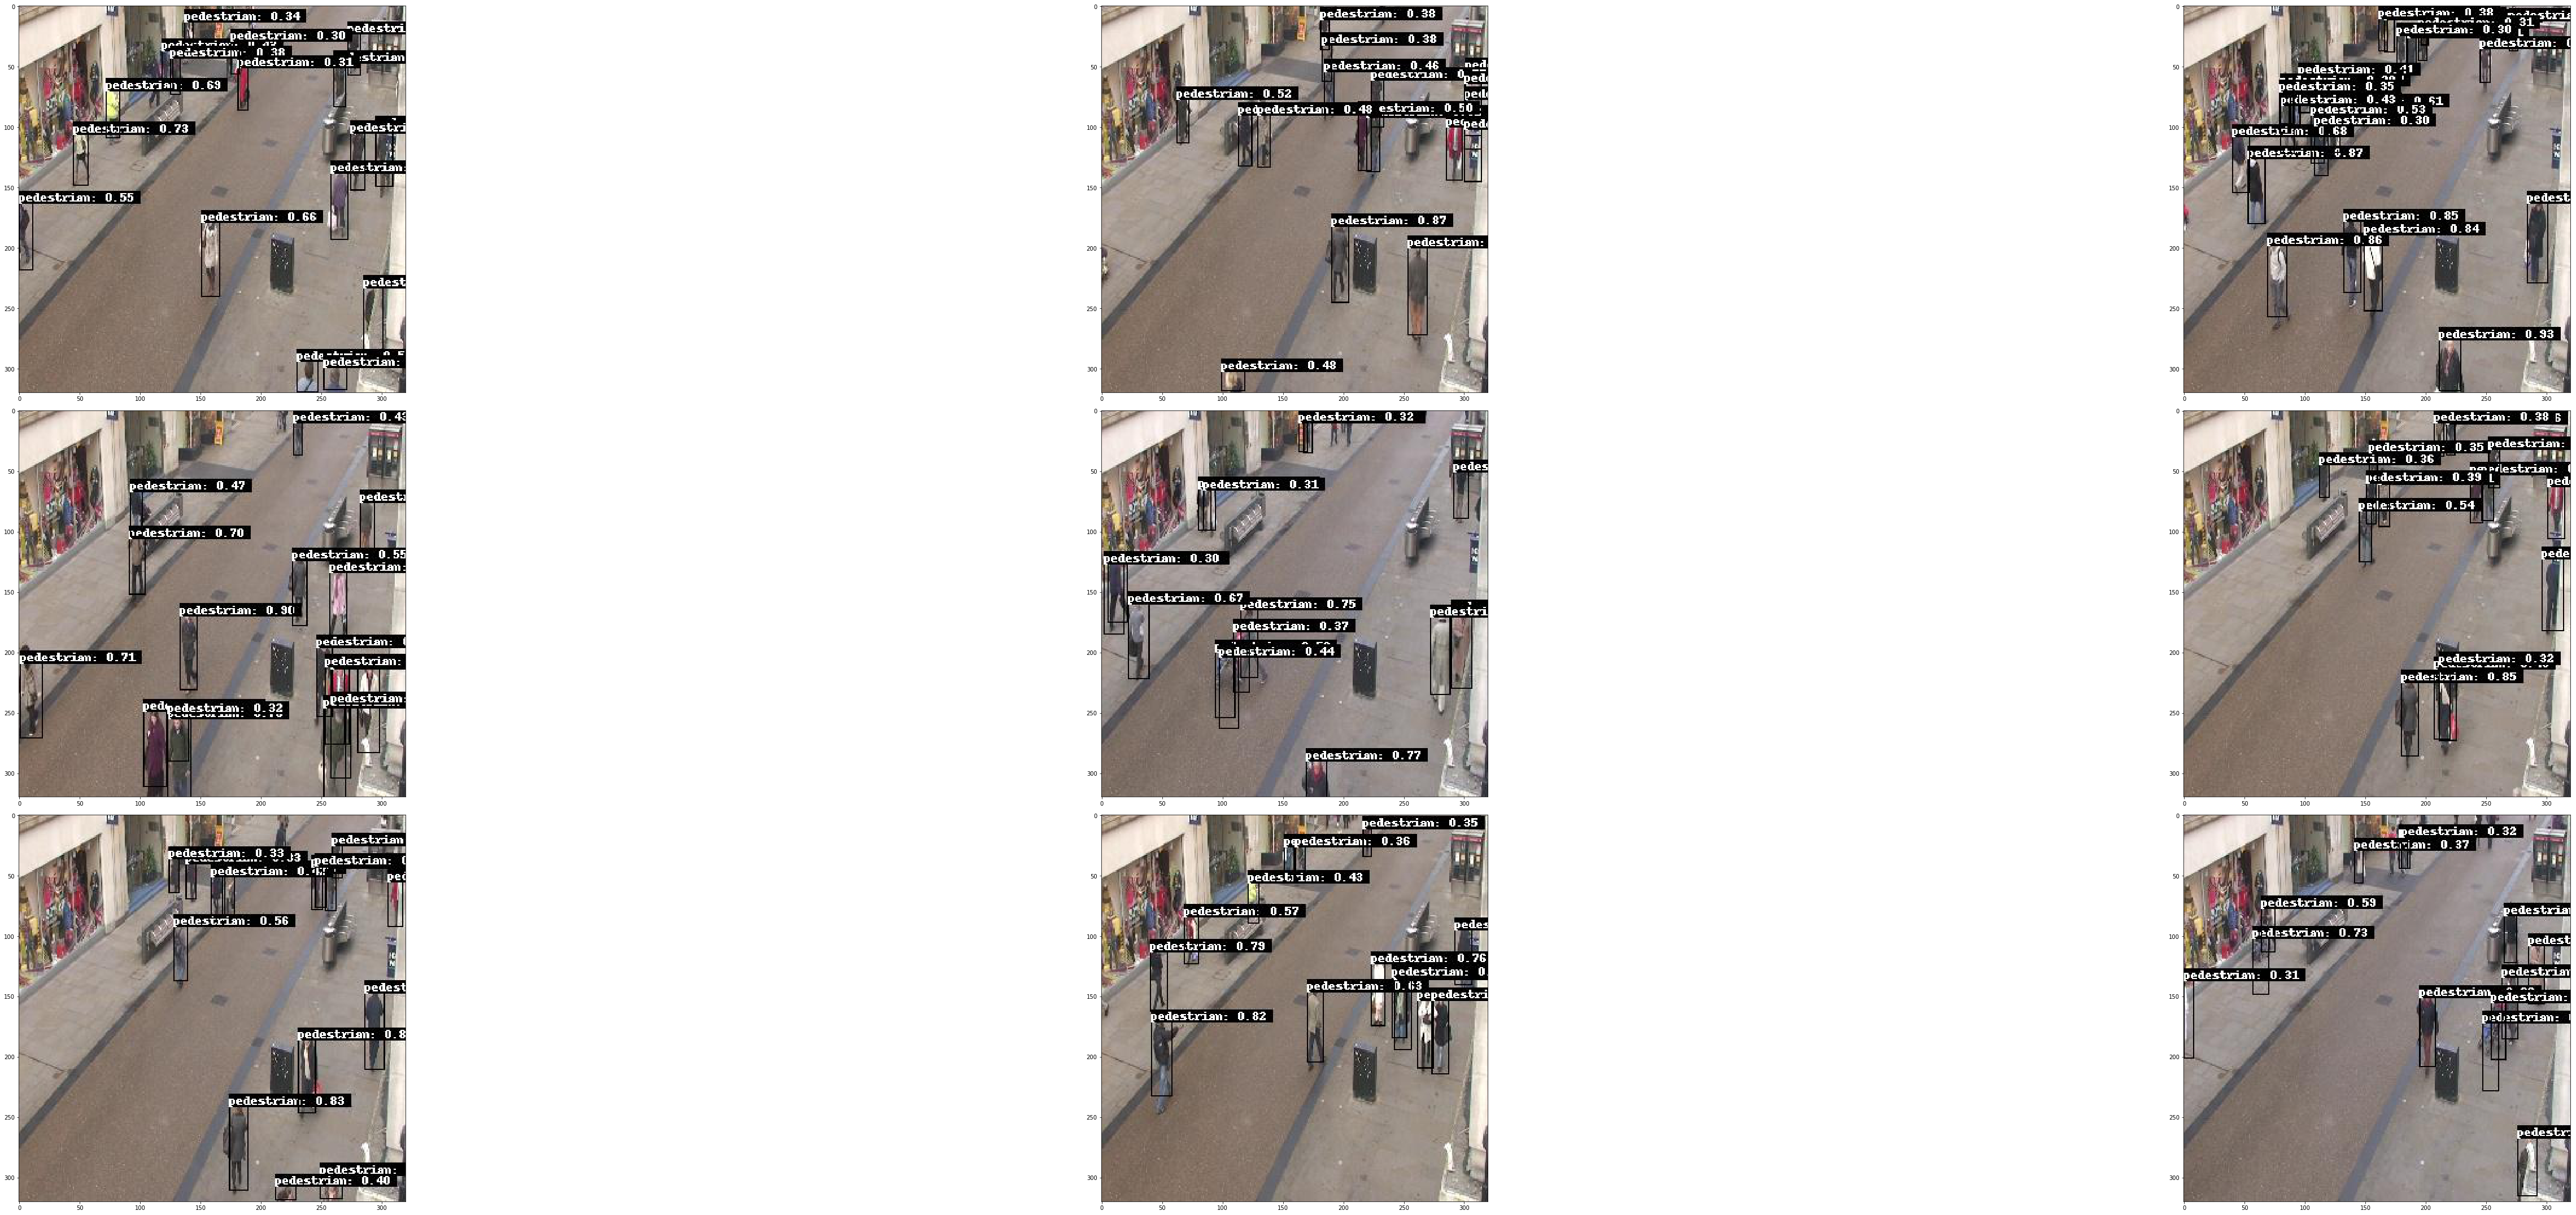

In [22]:
# Visualizing the sample images.
OUTPUT_PATH = 'ssd_infer_images' # relative path from $USER_EXPERIMENT_DIR.
COLS = 3 # number of columns in the visualizer grid.
IMAGES = 9 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 9. Deploy! <a class="anchor" id="head-9"></a>

In [23]:
!mkdir -p $USER_EXPERIMENT_DIR/export
# Export in FP32 mode. Change --data_type to fp16 for FP16 mode
!tlt-export ssd -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                -k $KEY \
                -o $USER_EXPERIMENT_DIR/export/ped_ssd_mobilenet_v2_epoch_$EPOCH.etlt \
                -e $SPECS_DIR/ped_ssd_mobilenet_v2_retrain.txt \
                --batch_size 1 \
                --data_type fp16

# Uncomment to export in INT8 mode (generate calibration cache file). \
# !tlt-export ssd -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_resnet18_epoch_$EPOCH.tlt  \
#                 -o $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt \
#                 -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
#                 -k $KEY \
#                 --cal_image_dir  $USER_EXPERIMENT_DIR/data/testing/image_2 \
#                 --data_type int8 \
#                 --batch_size 1 \
#                 --batches 10 \
#                 --cal_cache_file $USER_EXPERIMENT_DIR/export/cal.bin  \
#                 --cal_data_file $USER_EXPERIMENT_DIR/export/cal.tensorfile

Using TensorFlow backend.
2020-05-04 09:04:29,907 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /work/tlt/ped_ssd_mobilenet_v2/specs/ped_ssd_mobilenet_v2_retrain.txt
2020-05-04 09:04:32,904 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /work/tlt/ped_ssd_mobilenet_v2/specs/ped_ssd_mobilenet_v2_retrain.txt
NOTE: UFF has been tested with TensorFlow 1.14.0.
Converting NMS as custom op: NMS_TRT
Converting FirstDimTile_5 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_4 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_3 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_2 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_1 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_0 as custom op: BatchTilePlugin_TRT
DEBUG [/usr/lib/python2.7/dist-packages/uff/converters/tensorflow/converter.py:96] Marking ['NMS'] as outputs
[TensorRT] INFO: Dete

`Note:` In this example, for ease of execution we restrict the number of calibrating batches to 10. TLT recommends the use of at least 10% of the training dataset for int8 calibration.

In [24]:
print('Exported model:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/export

Exported model:
------------
total 3.3M
-rw-r--r-- 1 root root 3.3M May  4 09:04 ped_ssd_mobilenet_v2_epoch_110.etlt


Verify engine generation using the `tlt-converter` utility included with the docker.

The `tlt-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tlt-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the converter for jetson from the dev zone link [here](https://developer.nvidia.com/tlt-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [ ]:
# Convert to TensorRT engine (FP16)
!tlt-converter -k $KEY \
               -d 3,384,1248 \
               -o NMS \
               -e $USER_EXPERIMENT_DIR/export/trt.engine \
               -m 1 \
               -t fp16 \
               -i nchw \
               $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt

# Uncomment to convert to TensorRT engine (INT8).
# !tlt-converter -k $KEY  \
#                -d 3,384,1248 \
#                -o NMS \
#                -c $USER_EXPERIMENT_DIR/export/cal.bin \
#                -e $USER_EXPERIMENT_DIR/export/trt.engine \
#                -b 8 \
#                -m 1 \
#                -t int8 \
#                -i nchw \
#                $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt

In [ ]:
print('Exported engine:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/export/trt.engine

## 10. Verify the deployed model <a class="anchor" id="head-10"></a>
Verify the converted engine by visualizing TensorRT inferences.

In [ ]:
# Infer using TensorRT engine
# Note that tlt-infer currently only supports TensorRT engines with batch of 1. 
# Please make sure to use `-m 1` in tlt-converter and `--batch_size 1` in tlt-export

# When integrating with DS, please feel free to use any batch size that the GPU may be able to fit. 
# The engine batch size once created, cannot be alterred. So if you wish to run with a different batch-size,
# please re-run tlt-convert with the new batch-size for DS.

!tlt-infer ssd --trt -p $USER_EXPERIMENT_DIR/export/trt.engine \
                     -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
                     -i $DATA_DOWNLOAD_DIR/testing/image_2 \
                     -o $USER_EXPERIMENT_DIR/ssd_infer_images \
                     -t 0.4